<a href="https://colab.research.google.com/github/dpurbosakti/Dicoding_imageClassification_animalFaces/blob/master/Proyek_Ketiga_Image_Classification_TFLite_fix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os, zipfile

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
os.environ['KAGGLE_CONFIG_DIR']='/content/gdrive/MyDrive/kaggle_dataset'

In [ ]:
%cd /content/gdrive/MyDrive/kaggle_dataset

/content/gdrive/MyDrive/kaggle_dataset


In [ ]:
!ls

animal-faces.zip  kaggle.json


In [ ]:
!kaggle datasets download -d andrewmvd/animal-faces --force

100% 695M/696M [00:14<00:00, 116MB/s]
100% 696M/696M [00:14<00:00, 51.5MB/s]


In [ ]:
!ls

animal-faces.zip  kaggle.json


In [ ]:
os.mkdir("datasets")

In [ ]:
!ls

animal-faces.zip  datasets  kaggle.json


In [ ]:
zip_ref = zipfile.ZipFile('animal-faces.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders
input_folder = "files/afhq/train"
output = "datasets" 

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(0.8, 0.2))

Copying files: 14630 files [04:03, 60.10 files/s]


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
DIR = 'datasets/train'
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=40,
                    horizontal_flip=True,
                    shear_range=0.2,
                    fill_mode = 'nearest',
                    validation_split=0.2,)

In [ ]:
train_generator = train_datagen.flow_from_directory(
        DIR,  
        subset='training',
        target_size=(100, 150), 
        shuffle=True,
        class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
        DIR, 
        subset='validation',
        target_size=(100, 150),
        batch_size=32,
        class_mode='categorical')

Found 9363 images belonging to 3 classes.
Found 2340 images belonging to 3 classes.


In [ ]:
import tensorflow as tf
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(100, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')       
])

In [ ]:
model.compile(loss='categorical_crossentropy',
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               metrics=['accuracy'])

In [ ]:
def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)
tb_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs', histogram_freq=0, write_graph=True, write_images=False,
    update_freq='epoch', embeddings_freq=0,
    embeddings_metadata=None
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 148, 16)       448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 17, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 15, 128)        7

In [ ]:
batch_size = 16

hist = model.fit(train_generator, 
  epochs =  30, 
  steps_per_epoch = 660//batch_size, 
  validation_data = validation_generator, 
  verbose = 1, 
  validation_steps = 437//batch_size,
  callbacks =[lr_schedule, tb_callback])

Epoch 1/30

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
41/41 [==============================] - 42s 998ms/step - loss: 1.0565 - accuracy: 0.4329 - val_loss: 0.9666 - val_accuracy: 0.4988
Epoch 2/30

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
41/41 [==============================] - 41s 992ms/step - loss: 0.8659 - accuracy: 0.5953 - val_loss: 0.8197 - val_accuracy: 0.6632
Epoch 3/30

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
41/41 [==============================] - 50s 1s/step - loss: 0.6906 - accuracy: 0.7058 - val_loss: 0.5920 - val_accuracy: 0.7535
Epoch 4/30

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
41/41 [==============================] - 51s 1s/step - loss: 0.6141 - accuracy: 0.7447 - val_loss: 0.4882 - val_accuracy: 0.8171
Epoch 5/30

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0010000000474974513

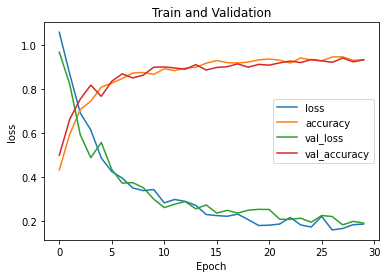

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.title('Train and Validation')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(loc='center right')
plt.show()

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with tf.io.gfile.GFile('imageclasmodel.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp__owi8i0/assets


Dwi Atmoko Purbo Sakti [Profile Dicoding](https://www.dicoding.com/users/dwi_atmoko)